In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
import glob
%pylab inline
#sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [2]:
files = glob.glob('../data/*.csv')
files


['../data\\battles.csv',
 '../data\\character-deaths.csv',
 '../data\\character-predictions.csv']

In [3]:
battles = pd.read_csv("../data/battles.csv")
character_deaths = pd.read_csv("../data/character-deaths.csv")
character_predictions = pd.read_csv("../data/character-predictions.csv")

In [26]:
battles.columns

Index(['name', 'year', 'battle_number', 'attacker_king', 'defender_king',
       'attacker_1', 'attacker_2', 'attacker_3', 'attacker_4', 'defender_1',
       'defender_2', 'defender_3', 'defender_4', 'attacker_outcome',
       'battle_type', 'major_death', 'major_capture', 'attacker_size',
       'defender_size', 'attacker_commander', 'defender_commander', 'summer',
       'location', 'region', 'note'],
      dtype='object')

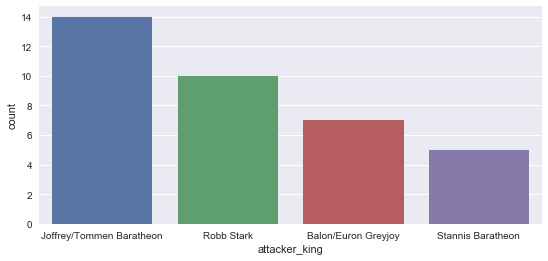

In [25]:
#tedad hamle ha
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
sns.countplot(data=battles, x='attacker_king')

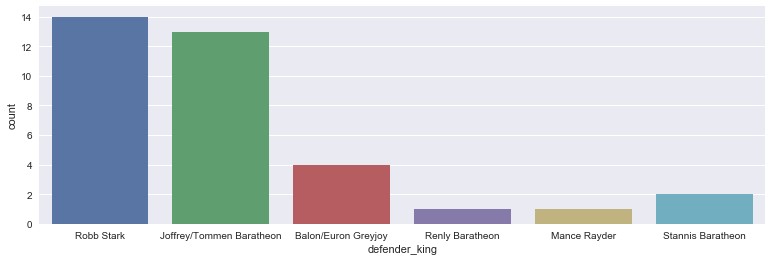

In [29]:
#tedad defa ha
fig, ax = plt.subplots()
fig.set_size_inches(13, 4)
sns.countplot(data=battles, x='defender_king')

In [30]:
battles.loc[:, "defender_count"] = (4 - battles[["defender_1", "defender_2", "defender_3", "defender_4"]].isnull().sum(axis = 1))
battles.loc[:, "attacker_count"] = (4 - battles[["attacker_1", "attacker_2", "attacker_3", "attacker_4"]].isnull().sum(axis = 1))
battles.loc[:, "att_comm_count"] = [len(x) if type(x) == list else np.nan for x in battles.attacker_commander.str.split(",")]


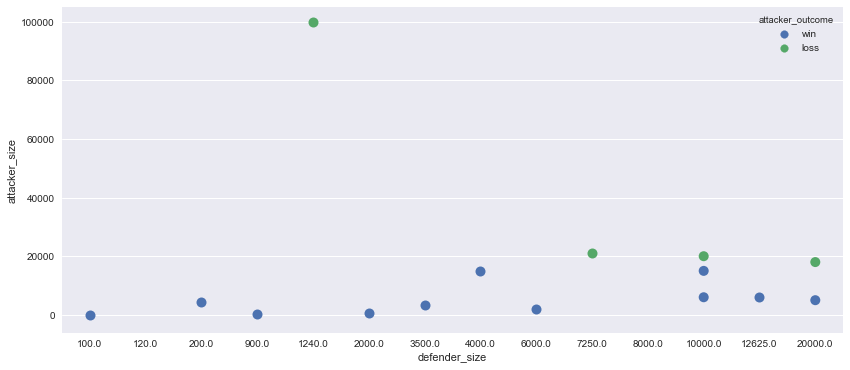

In [53]:
#nesbat artesh pirooz be bazande 
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
sns.swarmplot(y="attacker_size", x="defender_size", hue="attacker_outcome", 
              data=battles,size=10,)

In [56]:
#behtarin piroozi e defa konande ha
#hamle mardom azad b 
battles[battles.attacker_size == 100000]

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,...,defender_size,attacker_commander,defender_commander,summer,location,region,note,defender_count,attacker_count,att_comm_count
27,Battle of Castle Black,300,28,Stannis Baratheon,Mance Rayder,Free folk,Thenns,Giants,NaN,Night's Watch,...,1240.0,"Mance Rayder, Tormund Giantsbane, Harma Dogshe...","Stannis Baratheon, Jon Snow, Donal Noye, Cotte...",0.0,Castle Black,Beyond the Wall,NaN,2,3,5.0


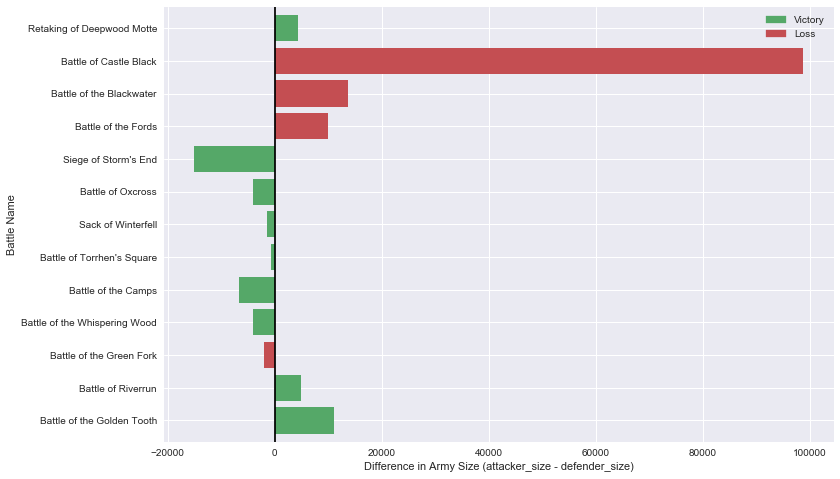

In [119]:
data = battles.dropna(subset = ["attacker_size", "defender_size"]).copy(deep = True)
data = pd.concat([(data.attacker_size - data.defender_size).to_frame(), battles[["attacker_outcome"]]], axis = 1, join = "inner")

data = data[data[0] != 0].dropna()

p = data[0].plot.barh(figsize = (12, 8), width = .8,
                  color = [[sns.color_palette()[1] if x == "win" 
                           else sns.color_palette()[2] if x == "loss" 
                           else "white" for x in data.attacker_outcome.values]])

_ = p.legend(handles = [mpatches.Patch(color = sns.color_palette()[1], label = "Victory", aa = True), 
                        mpatches.Patch(color = sns.color_palette()[2], label = "Loss", aa = True)])
_ = p.axvline(0, color = 'k'), p.set(yticklabels = battles.name.iloc[data.index].values,
                                     xlabel = "Difference in Army Size (attacker_size - defender_size)", 
                                     ylabel = "Battle Name")

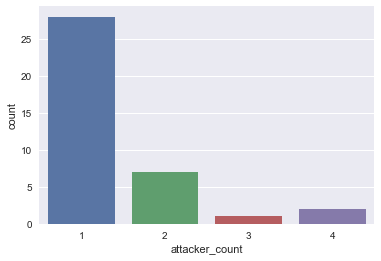

In [58]:
#ch qadr tooye hamle ha motehed mishan
sns.countplot(battles.attacker_count)

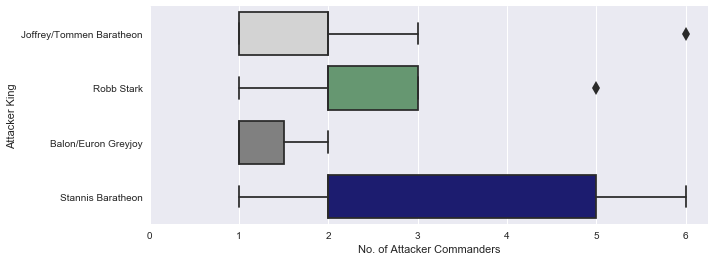

In [66]:
#har koodom az padeshah ha chanta farmande dashtn
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
p = sns.boxplot("att_comm_count", "attacker_king", data = battles, saturation = .6, fliersize = 10., palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "No. of Attacker Commanders", ylabel = "Attacker King", xticks = range(7))

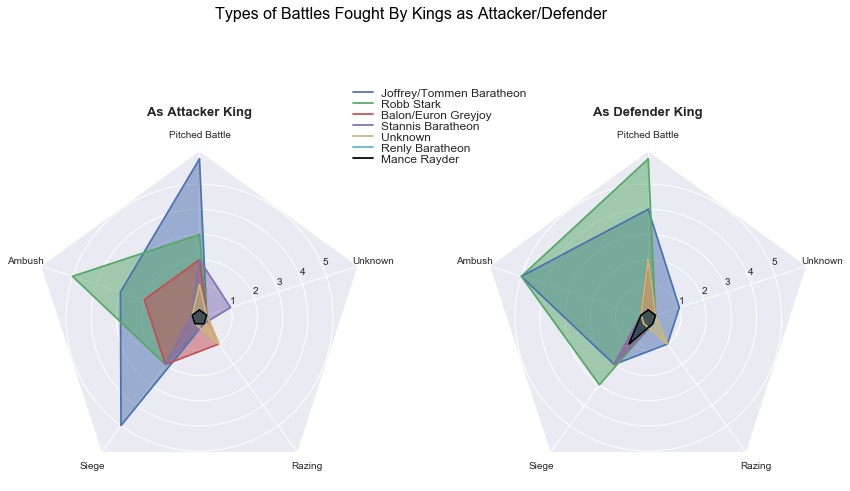

In [120]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame = "circle"):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint = False)
    theta += np.pi / 2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed = True, edgecolor = 'k')

    def draw_circle_patch(self):
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict: raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):
        name, RESOLUTION, draw_patch = 'radar', 1, patch_dict[frame]

        def fill(self, *args, **kwargs):
            closed = kwargs.pop("closed", True)
            return super(RadarAxes, self).fill(closed = closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines: self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == "circle": return PolarAxes._gen_axes_spines(self)
            spine_type, verts = "circle", unit_poly_verts(theta)
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

def unit_poly_verts(theta):
    x0, y0, r = [0.5] * 3
    verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
    return verts

kings = list(battles.attacker_king.append(battles.defender_king).fillna("Unknown").unique())
battle_types = list(battles.battle_type.fillna("Unknown").str.title().unique())

def example_data():
    data = battles[["battle_type", "attacker_king", "defender_king", "name"]].copy(deep = True).fillna("Unknown")
    data.loc[:, "battle_type"] = data.battle_type.fillna("Unknown").str.title()
    grouped, ret_data = data.groupby(["attacker_king", "battle_type"]).count()[["name"]], [battle_types]
    ret_data.append(("As Attacker King", [[grouped.loc[(kings[j], battle_types[i])].values[0]
                                    if (kings[j], battle_types[i]) in grouped.index else 0
                                    for i in range(len(battle_types))] for j in range(len(kings))]))
    grouped = data.groupby(["defender_king", "battle_type"]).count()[["name"]]
    ret_data.append(("As Defender King", [[grouped.loc[(kings[j], battle_types[i])].values[0]
                                    if (kings[j], battle_types[i]) in grouped.index else 0
                                    for i in range(len(battle_types))] for j in range(len(kings))]))
    return ret_data

N = 5
theta, data = radar_factory(N, frame = "polygon"), example_data()
spoke_labels, fig = data.pop(0), plt.figure(figsize = (14, 14))
fig.subplots_adjust(wspace = 0.35, hspace = 0.20, top = 0.85, bottom = 0.05)
colors = sns.color_palette() + ["k"]
for n, (title, case_data) in enumerate(data):
    ax, _ = fig.add_subplot(2, 2, n + 1, projection = "radar"), plt.rgrids([1, 2, 3, 4, 5])
    ax.set_title(title, weight = "bold", position = (0.5, 1.1), horizontalalignment = "center", verticalalignment = "center", fontsize = 13.)
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color = color)
        ax.fill(theta, d, facecolor = color, alpha = 0.5)
    ax.set_varlabels(spoke_labels)
plt.subplot(2, 2, 1)
labels = kings
legend = plt.legend(labels, loc = (.95, .95), labelspacing = 0.1)
plt.setp(legend.get_texts(), fontsize = "large")
plt.figtext(0.5, 0.965, "Types of Battles Fought By Kings as Attacker/Defender", ha = "center", color = "k", size = 16.)
plt.show()